In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Helps visualize higher dimensions data
import missingno as msno # Missing Data visualization
import seaborn as sns
sns.set(style="white")
%matplotlib inline

from sklearn.preprocessing import StandardScaler, normalize  # Helps us in Standardizing the data
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
                                                                                                             # metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.cluster import KMeans # Clustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, BorderlineSMOTE # Oversampling

import time
from datetime import datetime
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
seed = 0

### Import data

In [2]:
df = pd.read_csv('data_corona/desc_train.csv')
df.head()

,Smiles,Activity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N,0,9.950184,-1.189130,9.950184,0.218049,0.490520,267.245,254.141,267.096754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1(C(=O)NC(=O)N1)NC(=O)N,0,10.655463,-1.041667,10.655463,0.616852,0.325138,158.117,152.069,158.043990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,C1C2C(C(S1)CCCCC(=O)O)NC(=O)N2,0,11.112311,-0.728901,11.112311,0.064041,0.493478,244.316,228.188,244.088163,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,C1C2C(C(S1)CCCCC(=O)O)NC(=O)N2,0,11.112311,-0.728901,11.112311,0.064041,0.493478,244.316,228.188,244.088163,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,C1C2C(C(S1)CCCCC(=O)O)NC(=O)N2,0,11.112311,-0.728901,11.112311,0.064041,0.493478,244.316,228.188,244.088163,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


(189001, 202)
0    188386
1       615
Name: Activity, dtype: int64


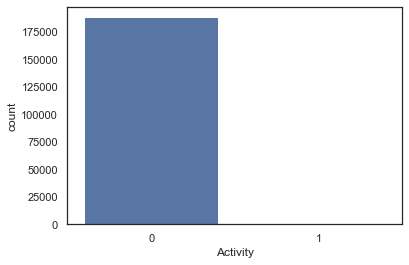

In [3]:
target = "Activity"
sns.countplot(x=target, data=df)
print(df.shape)
print(df[target].value_counts())

In [4]:
df = df.drop(["Smiles"], axis = 1)
#Drop duplicate rows
df = df.drop_duplicates(ignore_index=True)
#Drop non info columns
columns = df.columns[[len(np.unique(df[col])) == 1 for col in df.columns]]
df = df.drop(columns,axis = 1)
X_df = df.drop(target, axis = 1)
Y_df = df[target]

### Missing Values Imputation

<Figure size 1152x432 with 0 Axes>

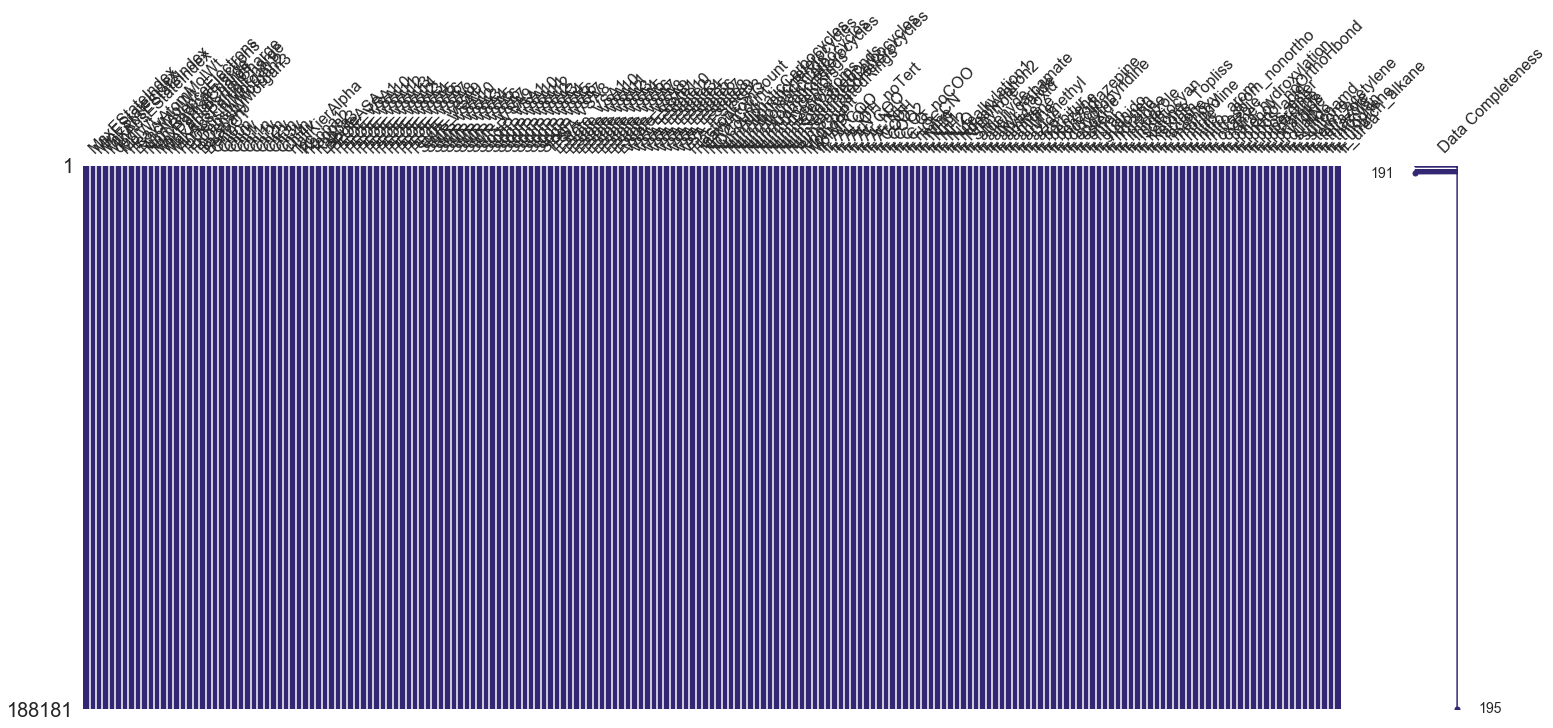

In [5]:
plt.figure(figsize=(16,6))
msno.matrix(X_df,labels = True, color=(0.20,0.15,0.45))

In [6]:
print(X_df.columns[X_df.isnull().sum() > 0])
X_df.isnull().sum().sum()

Index(['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge'],
      dtype='object')


100

In [7]:
X_df = X_df.fillna(X_df.median())

0

<Figure size 1152x432 with 0 Axes>

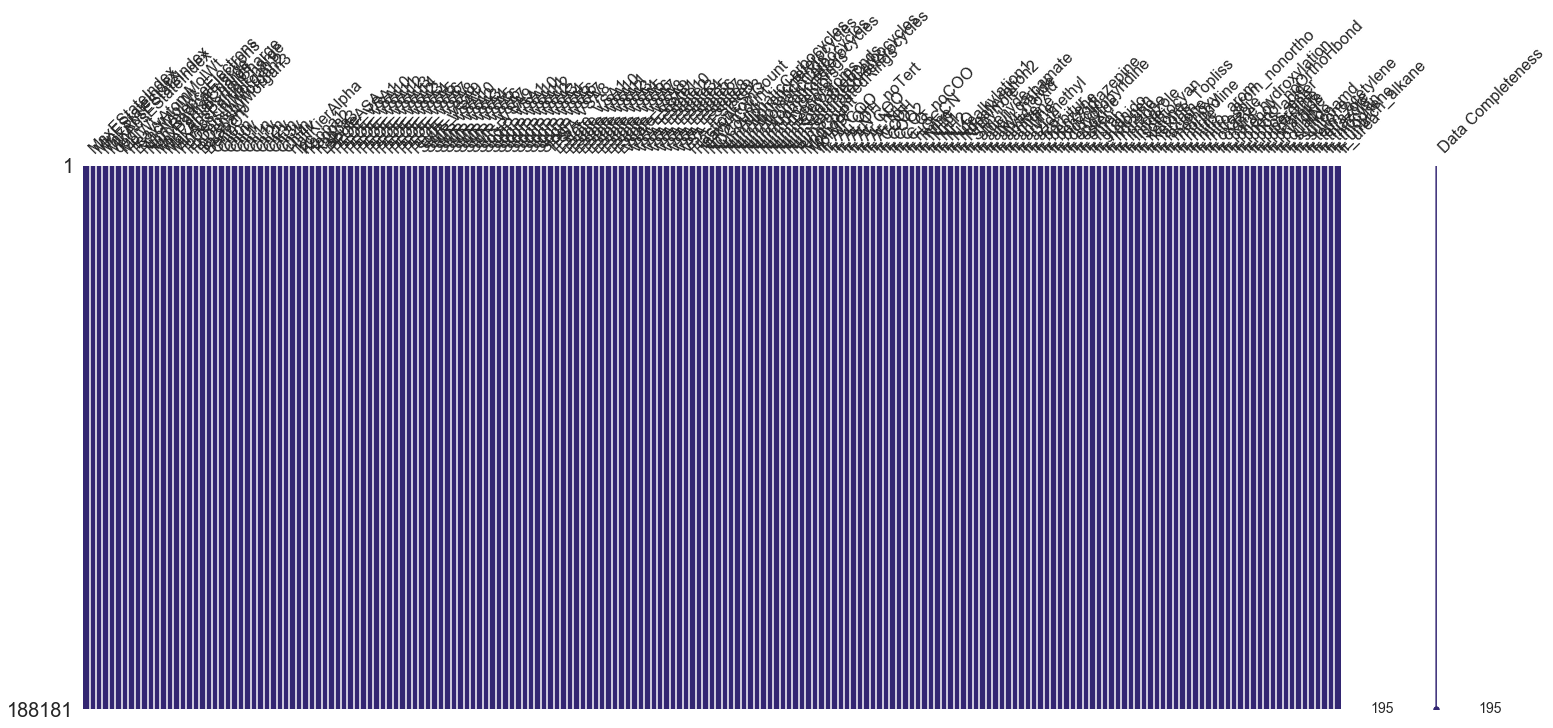

In [8]:
#Recheck missing values after Imputation
plt.figure(figsize=(16,6))
msno.matrix(X_df,labels = True, color=(0.20,0.15,0.45))
X_df.isnull().sum().sum()

# Train Test Split

In [9]:
X_train_df, X_val_df, Y_train_df, Y_val_df = train_test_split(X_df,Y_df, test_size=0.20, random_state=seed)

In [10]:
print(X_train_df.shape)
print(Y_train_df.shape)

(150544, 195)
(150544,)


In [11]:
print(X_val_df.shape)
print(Y_val_df.shape)
Y_val = Y_val_df.values

(37637, 195)
(37637,)


### Lets draw heatmap to check multi collinearity

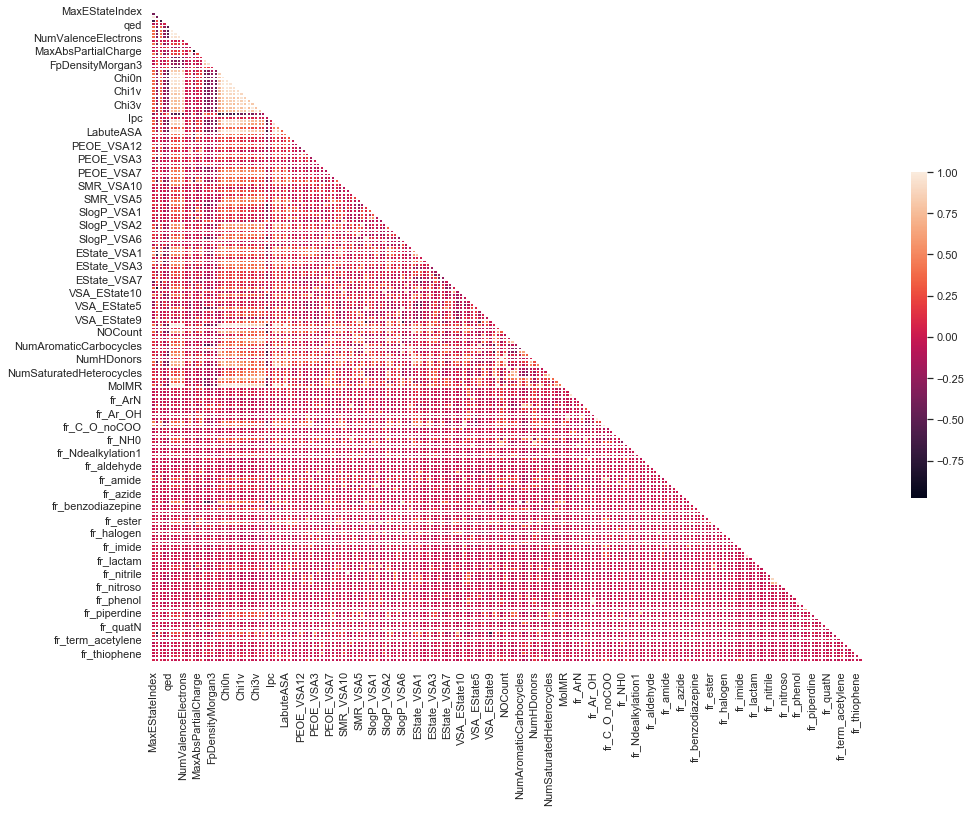

In [12]:
fig, ax = plt.subplots(figsize=(16,12)) 
corr = X_train_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

 
sns.heatmap(corr, mask=mask,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
# A condition to filter all the columns where collinearity with other columns is greater than 0.5 and less than 1.0
high_corr_attr = corr[(corr.abs()>0.5)].count().sort_values(ascending= False)
print(list(high_corr_attr))

[34, 32, 32, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 29, 29, 28, 28, 28, 28, 28, 26, 26, 26, 25, 24, 24, 24, 19, 19, 17, 16, 13, 13, 12, 12, 11, 11, 11, 10, 10, 10, 9, 9, 9, 8, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
#There are  18 columns which has correlation of more than 0.8
cols_to_be_dropped = list(high_corr_attr[high_corr_attr > 12].index)

In [15]:
print(len(cols_to_be_dropped))
#cols_to_be_dropped

33


In [16]:
X_train_df = X_train_df.drop(cols_to_be_dropped, axis = 1) # Dropping columns
X_val = X_val_df.drop(cols_to_be_dropped, axis = 1).values

In [17]:
X_train_df.shape

(150544, 162)

(array([  0.5,   3.5,   6.5,   9.5,  12.5,  15.5,  18.5,  21.5,  24.5,
         27.5,  30.5,  33.5,  36.5,  39.5,  42.5,  45.5,  48.5,  51.5,
         54.5,  57.5,  60.5,  63.5,  66.5,  69.5,  72.5,  75.5,  78.5,
         81.5,  84.5,  87.5,  90.5,  93.5,  96.5,  99.5, 102.5, 105.5,
        108.5, 111.5, 114.5, 117.5, 120.5, 123.5, 126.5, 129.5, 132.5,
        135.5, 138.5, 141.5, 144.5, 147.5, 150.5, 153.5, 156.5, 159.5]),
 <a list of 54 Text xticklabel objects>)

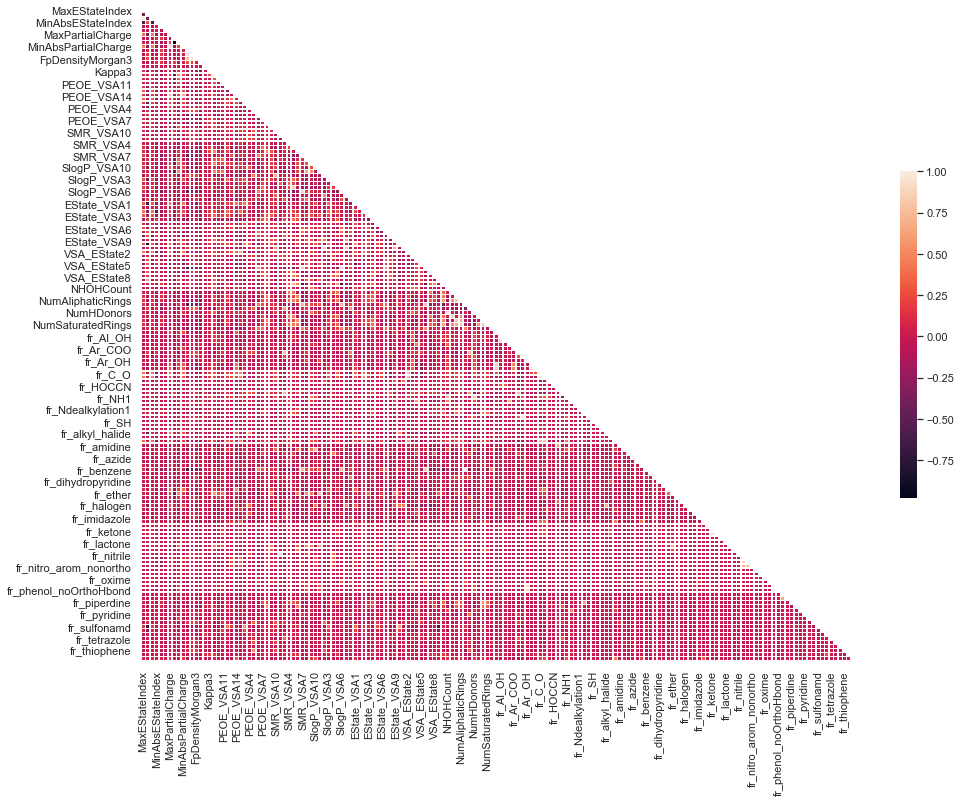

In [18]:
# Lets check the heatmap again
fig, ax = plt.subplots(figsize=(16,12)) 
corr = X_train_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

 
sns.heatmap(corr, mask=mask,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=90)

In [29]:
print(X_val_df.head())
X_train_df.head()

        MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
129687       12.214363       -0.225431          12.214363           0.017840   
90005        12.795679       -3.675815          12.795679           0.143801   
151667       11.966328       -0.474790          11.966328           0.474790   
178773       12.830353       -3.446264          12.830353           0.044496   
36177        12.466228       -3.780958          12.466228           0.054307   

             qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
129687  0.698260  346.471         316.231  346.225643                138.0   
90005   0.768965  371.462         350.294  371.130363                136.0   
151667  0.540414  357.395         342.275  357.089560                128.0   
178773  0.476418  485.606         454.358  485.198442                182.0   
36177   0.735892  379.390         362.254  379.072573                138.0   

        NumRadicalElectrons  ...  fr_sulfide  fr_s

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
180858,12.496513,0.310625,12.496513,0.310625,0.915529,0.0,0.225250,-0.380528,0.380528,0.225250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57184,11.220805,-1.232621,11.220805,0.158610,0.552997,0.0,0.335439,-0.477636,0.477636,0.335439,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
72032,12.196829,-0.102749,12.196829,0.102749,0.685533,0.0,0.277906,-0.266948,0.277906,0.266948,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73691,12.398620,-4.639664,12.398620,0.198285,0.918961,0.0,0.340673,-0.347962,0.347962,0.340673,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113360,12.330918,-0.653591,12.330918,0.057127,0.575097,0.0,0.272791,-0.496766,0.496766,0.272791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Resampling of data using SMOTE Technique
As we saw earlier this is a high imbalance data. By doing some oversampling we can add new rows to our data with target as minority class (In this case 1)

Data Imbalances happen for a reason. The reason - <b> rare occuring events </b>. Some events have rare occurences but when they do they have huge impact.
Something like cancer, meteor falling on Earth and killing Dinosaurs or Mortgage backed Security crisis of 2008, or something like Bankruptcy. So one has to take care of using an optimal ratio of while smoting. One shouldnot use a high ratio as these occurences are rare. 

In [20]:
# Lets check the imbalance first
num_pos = sum(Y_train_df == 1)
num_neg = sum(Y_train_df == 0)
print(num_pos/num_neg)
print('The Imbalance is: {}'.format(num_neg / num_pos))

0.0032454334019739167
The Imbalance is: 308.1252566735113


In [21]:
#sm = SMOTE(ratio={1:1965},kind='borderline1',random_state=42) # lets reduce the imbalance 
sm = BorderlineSMOTE(random_state=42)
X_res, Y_res = sm.fit_sample(X_train_df.values, Y_train_df.values)

In [22]:
print(X_res.shape)
print(Y_res.shape)

(300114, 162)
(300114,)


In [23]:
# Lets check the imbalance first
num_pos = sum(Y_res == 1)
num_neg = sum(Y_res == 0)
print('The Imbalance is reduced now and stands at: {}'.format( num_neg/num_pos))

The Imbalance is reduced now and stands at: 1.0


### Lets apply different machine learning models

1. Logistic Regression
2. SVM
3. Random Forests
4. AdaBoost
5. XGBoost

#### Creating Instances

In [24]:
# Lets stick to default Hyperparametrs as of now. We shall tune the best model
log_reg = LogisticRegression(random_state= 42)
svc = SVC(random_state= 42)
rf = RandomForestClassifier(random_state= 42)
ada = AdaBoostClassifier(random_state= 42)
xgb = XGBClassifier(random_state= 42)

A small function that loops through the instances above and stores evaluation metrics of each classifier in a dictionary

In [25]:

def training_predict(trainer, X_train, Y_train, X_test, Y_test):
    print(trainer.__class__.__name__)
    scores = {} # Initializing a Dictionary to store evaluation metrics
    params = {"scale_pos_weight": np.sqrt(sum(Y_train == 0) / sum(Y_train == 1))}
    trainer.set_params(**params)
    trainer.fit(X_train, Y_train)  # Training
    Y_pred = trainer.predict(X_test) # Predicts
    
    '''
    Stores the result of trainer in its individual Key
    '''
    scores['Accuracy_test'] = accuracy_score(Y_test , Y_pred)  
    
    scores['Recall_test'] = recall_score(Y_test , Y_pred)
    
    scores['Precision_test'] = precision_score(Y_test , Y_pred)
    
    scores['F1_Score_test'] = f1_score(Y_test , Y_pred)
    
    
    return scores

In [26]:
print(X_res.shape)
print(Y_res.shape)
print('\n')
print(X_val.shape)
print(Y_val.shape)

(300114, 162)
(300114,)


(37637, 162)
(37637,)


In [27]:
# Ignore the error
predictors = {} # Initializing a dictionary to store training and testing data
for model in [xgb]:#[log_reg, svc, rf, ada, xgb]: # these are our objects that we instantiated above. We loop through them
    model_name = model.__class__.__name__
    predictors[model_name]  = {}
    predictors[model_name] =  training_predict(model, X_res, Y_res, X_val, Y_val) #Scores that is returned from trainer goes to
                                                                             # the respective predictor
    

XGBClassifier


In [28]:
pd.DataFrame(predictors).T

,Accuracy_test,F1_Score_test,Precision_test,Recall_test
XGBClassifier,0.996493,0.09589,0.388889,0.054688


The above scores are on the base of Smoting at 7% from 4.8% for minoirty class

However we can try different ratios in Smote and try models on different samples.

Lets try some values in Smote and run the iterations again

In [37]:
smote_values = np.linspace((sum(Y_train_df == 1) + 2)/sum(Y_train_df == 0), 0.017, num= 15)
smote_values

array([0.00325876, 0.00424028, 0.0052218 , 0.00620331, 0.00718483,
       0.00816635, 0.00914786, 0.01012938, 0.0111109 , 0.01209241,
       0.01307393, 0.01405545, 0.01503697, 0.01601848, 0.017     ])

In [38]:
#Ignore the errors
start = time.time()

panel = {} # Saves key as smoting ratio and dictionary is the result of each classifier

for value in smote_values:
    sm = BorderlineSMOTE(value, random_state=42)
    X_res, Y_res = sm.fit_sample(X_train_df.values, Y_train_df.values)

    print('Loop for smote value {} started at {}'.format(value, datetime.now().strftime("%H:%M:%S")))
   
    predictors = {} # Initializing a dictionary to store training and testing data
 
    for model in [xgb]:#[log_reg, svc, rf, ada, xgb]:
        model_name = model.__class__.__name__
        predictors[model_name]  = {}
        predictors[model_name] =  training_predict(model, X_res, Y_res, X_val, Y_val) #Scores that is returned from trainer goes to
    
    panel[value] = predictors  # the respective predictor
            
    print('Loop Ended at {}'.format(datetime.now().strftime("%H:%M:%S")))
    print('\n')
    
print('Loop took {} mins'.format((time.time() - start) / 60))

Loop for smote value 0.003258761670565185 started at 12:13:45
XGBClassifier
Loop Ended at 12:14:44


Loop for smote value 0.004240278694096243 started at 12:14:59
XGBClassifier
Loop Ended at 12:16:00


Loop for smote value 0.005221795717627302 started at 12:16:16
XGBClassifier
Loop Ended at 12:17:19


Loop for smote value 0.006203312741158359 started at 12:17:37
XGBClassifier
Loop Ended at 12:18:41


Loop for smote value 0.007184829764689418 started at 12:18:57
XGBClassifier
Loop Ended at 12:20:09


Loop for smote value 0.008166346788220476 started at 12:20:26
XGBClassifier
Loop Ended at 12:21:30


Loop for smote value 0.009147863811751535 started at 12:21:47
XGBClassifier
Loop Ended at 12:22:57


Loop for smote value 0.010129380835282593 started at 12:23:14
XGBClassifier
Loop Ended at 12:24:36


Loop for smote value 0.011110897858813652 started at 12:24:53
XGBClassifier
Loop Ended at 12:26:13


Loop for smote value 0.01209241488234471 started at 12:26:29
XGBClassifier
Loop Ended at 12

In [39]:
smote_iterated_df = pd.DataFrame()
for key in panel:
    temp_df = pd.DataFrame(panel[key]).T
    temp_df['Smote'] = key
    temp_df.index.name = 'Class'
    temp_df.reset_index(inplace= True)
    temp_df.set_index(['Smote','Class'], inplace= True)
    smote_iterated_df = smote_iterated_df.append(temp_df)

In [40]:
smote_iterated_df.head(15)

,,Accuracy_test,F1_Score_test,Precision_test,Recall_test
Smote,Class,,,,
0.003259,XGBClassifier,0.996147,0.171429,0.319149,0.117188
0.004240,XGBClassifier,0.996280,0.195402,0.369565,0.132812
0.005222,XGBClassifier,0.996413,0.237288,0.428571,0.164062
0.006203,XGBClassifier,0.996201,0.182857,0.340426,0.125000
0.007185,XGBClassifier,0.996227,0.202247,0.360000,0.140625
0.008166,XGBClassifier,0.996254,0.165680,0.341463,0.109375
0.009148,XGBClassifier,0.996094,0.178771,0.313725,0.125000
0.010129,XGBClassifier,0.996387,0.190476,0.400000,0.125000
0.011111,XGBClassifier,0.996413,0.201183,0.414634,0.132812


Recall Score is what we are interested in. Recall shows our model's ability to predict Positive as Positive. Since our Data is highly imbalance, it is difficult for any model to get a better recall. Sometime models ignores the minority class


In [43]:
# Lets rearrange Recall_test score in descending order
smote_iterated_df['Recall_test'].sort_values(ascending = False).head(5)

Smote     Class        
0.005222  XGBClassifier    0.164062
0.007185  XGBClassifier    0.140625
0.017000  XGBClassifier    0.132812
0.014055  XGBClassifier    0.132812
0.011111  XGBClassifier    0.132812
Name: Recall_test, dtype: float64

In [44]:
smote_iterated_df['Recall_test'].idxmax() # Finding the Smote_Ratio and Class for the largest Recall Score

(0.005221795717627302, 'XGBClassifier')

In [45]:
smote_iterated_df.to_csv('Smote_iteration.csv', sep=',')

### PreTune and Post Tune

In [48]:
# Ignore Error
sm = BorderlineSMOTE(0.005221795717627302, random_state=42)
X_res, Y_res = sm.fit_sample(X_train_df, Y_train_df)

print(X_res.shape)
print(Y_res.shape)
print('\n')
print(X_val.shape)
print(Y_val.shape)

(150840, 162)
(150840,)


(37637, 162)
(37637,)


In [49]:
X_res.to_csv("data_corona/X_train_smote.csv", index = False, header = True)
Y_res.to_csv("data_corona/Y_train_smote.csv", index = False, header = True)
X_val_df.drop(cols_to_be_dropped, axis = 1).to_csv("data_corona/X_val_smote.csv", index = False, header = True)
Y_val_df.to_csv("data_corona/Y_val_smote.csv", index = False, header = True)

# Test

In [20]:
X_test_df = pd.read_csv('data_corona/desc_test.csv')
X_test_df.head()

,Smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C1=CC(=C(C=C1C(=O)O)O)O,10.271704,-1.138611,10.271704,0.055278,0.522491,154.121,148.073,154.026609,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C(CC(=O)O)CN,9.702639,-0.772731,9.702639,0.190972,0.520009,103.121,94.049,103.063329,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C1C2C(C(S1)CCCCC(=O)O)NC(=O)N2,11.112311,-0.728901,11.112311,0.064041,0.493478,244.316,228.188,244.088163,90.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,C1=CC(=CC=C1C(C(CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-],11.304786,-1.325823,11.304786,0.132301,0.409071,323.132,311.036,322.012327,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C1=CC=C(C(=C1)C(=O)O)O,10.261759,-1.112870,10.261759,0.067130,0.610259,138.122,132.074,138.031694,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_test_df = X_test_df.drop(["Smiles"], axis = 1)
X_test_df = X_test_df.drop(columns, axis = 1)
X_test_df = X_test_df.drop(cols_to_be_dropped, axis = 1)
X_test_df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.271704,-1.138611,10.271704,0.055278,0.522491,0.0,0.335323,-0.504260,0.504260,0.335323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.702639,-0.772731,9.702639,0.190972,0.520009,0.0,0.302889,-0.481230,0.481230,0.302889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.112311,-0.728901,11.112311,0.064041,0.493478,0.0,0.314936,-0.481230,0.481230,0.314936,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,11.304786,-1.325823,11.304786,0.132301,0.409071,0.0,0.268945,-0.394123,0.394123,0.268945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.261759,-1.112870,10.261759,0.067130,0.610259,0.0,0.338969,-0.507053,0.507053,0.338969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 1152x432 with 0 Axes>

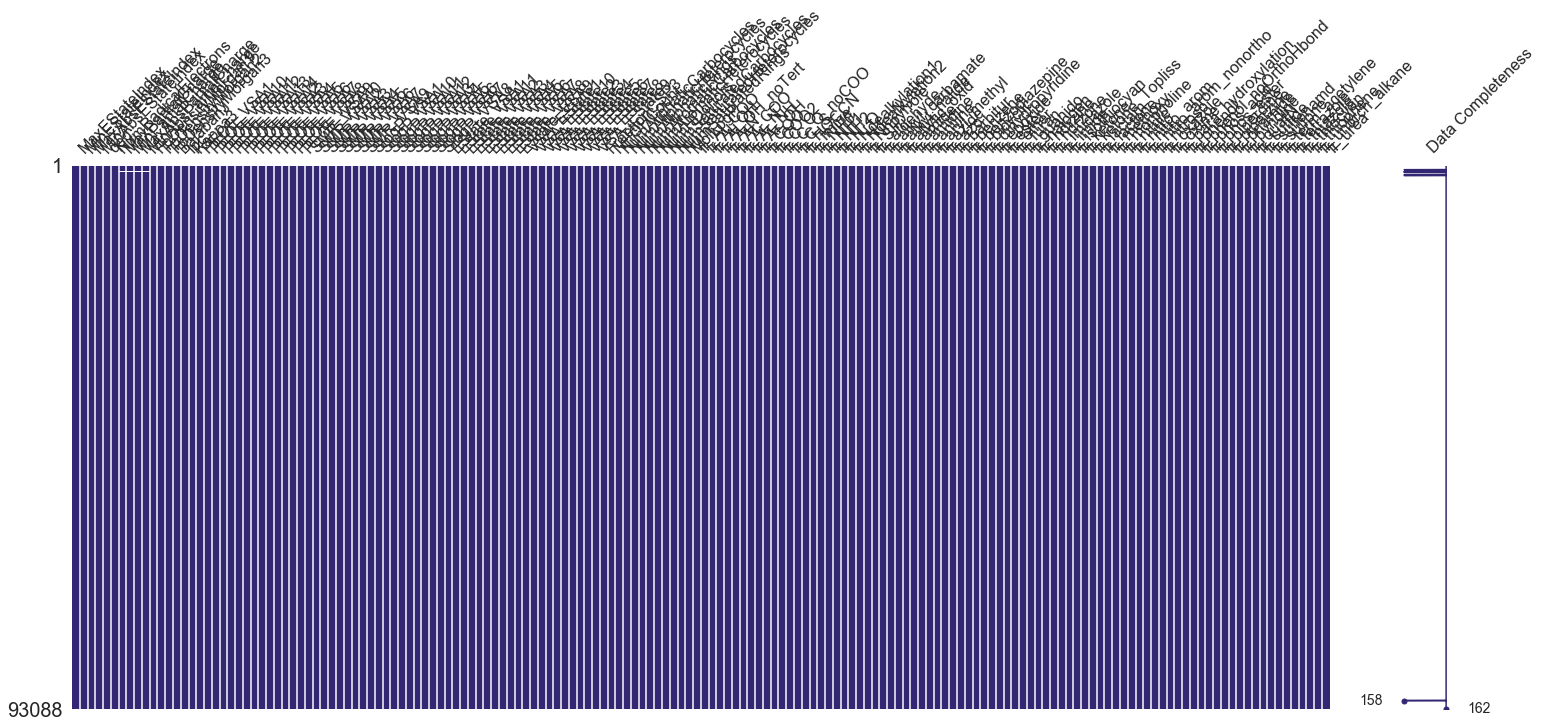

In [22]:
# Plotting NA values
plt.figure(figsize=(16,6))
msno.matrix(X_test_df, labels = True, color=(0.20,0.15,0.45))

#### Imputation

In [23]:
X_test_df.isnull().sum().sum() #Checking total number of missing values

48

In [24]:
X_test_df = X_test_df.fillna(X_df.median()) # Imputing Null values with train set Median

In [25]:
X_test_df.isnull().sum().sum()

0

<Figure size 1152x432 with 0 Axes>

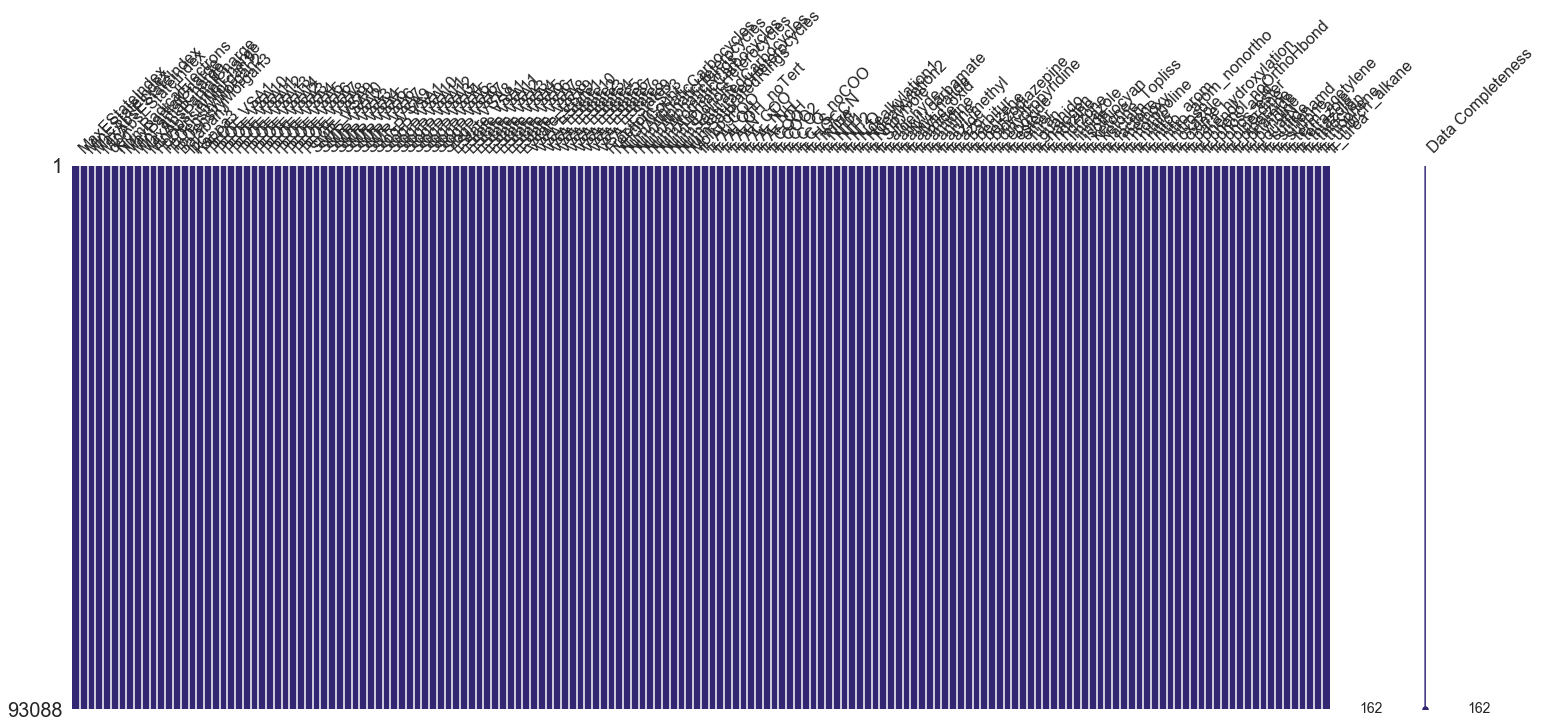

In [26]:
#Rechecking missing values after Imputation
plt.figure(figsize=(16,6))
msno.matrix(X_test_df, labels = True, color=(0.20,0.15,0.45))

#### Dropping columns to bring test data in same dimension to train model. We will use the same cols_to_be_dropped list which has irrelevant columns

In [27]:
X_test_df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.271704,-1.138611,10.271704,0.055278,0.522491,0.0,0.335323,-0.504260,0.504260,0.335323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.702639,-0.772731,9.702639,0.190972,0.520009,0.0,0.302889,-0.481230,0.481230,0.302889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.112311,-0.728901,11.112311,0.064041,0.493478,0.0,0.314936,-0.481230,0.481230,0.314936,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,11.304786,-1.325823,11.304786,0.132301,0.409071,0.0,0.268945,-0.394123,0.394123,0.268945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.261759,-1.112870,10.261759,0.067130,0.610259,0.0,0.338969,-0.507053,0.507053,0.338969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_test_df.to_csv("data_corona/X_test_smote.csv", header = True, index= False)